# First evaluation insights
So far just copied from eval.py but meant to be used for more strucutred plotting and analysis.

In [25]:
%matplotlib inline
import glob
import yaml
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# network prefix to filter results
prefix = 'Airtel'

Airtel is a medium-large network with nodes far away from each other. This leads to high link delays and lower impact of rounding link delays to full integers, which was a problem with the very dense Colt network.

![Airtel](http://topology-zoo.org/maps/Airtel.jpg)

In [26]:
# load emulation results and calculate RTT
emu_results = glob.glob('emulation/{}*.yaml'.format(prefix))
emu_delays = []
for result_file in emu_results:
    with open(result_file, 'r') as f:
        result = yaml.load(f)

        # chain delays = httping = TCP handshake = 2x RTT
        result['chain_rtt'] = result['chain_delay']['delay'] / 2

        # vnf delays = ping = RTT
        for delay in result['delays']:
            delay['rtt'] = delay['delay']

        emu_delays.append(result)

In [27]:
# load simulation results and calculate RTT (from bjointsp)
sim_results = glob.glob('bjointsp/{}*.yaml'.format(prefix))
sim_delays = []
for result_file in sim_results:
    with open(result_file, 'r') as f:
        result = yaml.load(f)

        # one-way = RTT/2
        result['chain_rtt'] = result['metrics']['total_delay'] * 2
        for delay in result['metrics']['delays']:
            delay['rtt'] = delay['delay'] * 2

        sim_delays.append(result)

Combine the results from emulation and simulation:
1. Sort and match results for chain and inter-VNF delays
2. Create ordered data frame for easier comparison and evaluation

In [28]:
# create empty data frames
input_cols = ['network', 'num_nodes', 'num_edges', 'service', 'num_vnfs', 'sources', 'num_sources', 'model']
chain_df = pd.DataFrame(columns=input_cols + ['sim_rtt', 'emu_rtt'])
vnf_df = pd.DataFrame(columns=input_cols + ['src', 'dest', 'sim_rtt', 'emu_rtt'])
chain_index = 0
vnf_index = 0

# TODO: clean up
# match and sort chain and inter-VNF RTTs and insert into data frames
emu_chain_rtt, sim_chain_rtt = [], []
emu_vnf_rtt, sim_vnf_rtt = [], []
for emu in emu_delays:
    for sim in sim_delays:
        # match chain delays (same input: network, service, sources)
        if emu['input']['network'].endswith(sim['input']['network']) \
                and emu['input']['service'].endswith(sim['input']['service']) \
                and emu['input']['sources'].endswith(sim['input']['sources']):
            emu_chain_rtt.append(emu['chain_rtt'])
            sim_chain_rtt.append(sim['chain_rtt'])
            
            # insert into data frame
            inputs = [sim['input']['network'], sim['input']['num_nodes'], sim['input']['num_edges'], 
                      sim['input']['service'], sim['input']['num_vnfs'],
                      sim['input']['sources'], sim['input']['num_sources'], sim['input']['model']]
            # somehow the simulation RTT needs to be cast to float explicitly
            chain_df.loc[chain_index] = inputs + [float(sim['chain_rtt']), emu['chain_rtt']]
            chain_index += 1

            # match inter-VNF RTTs (same input + src, dest)
            for emu_vnf in emu['delays']:
                for sim_vnf in sim['metrics']['delays']:
                    if emu_vnf['src'] == sim_vnf['src'] and emu_vnf['dest'] == sim_vnf['dest']:
                        emu_vnf_rtt.append(emu_vnf['rtt'])
                        sim_vnf_rtt.append(sim_vnf['rtt'])
                        
                        # insert into data frame
                        vnf_df.loc[vnf_index] = inputs + [sim_vnf['src'], sim_vnf['dest'], float(sim_vnf['rtt']), emu_vnf['rtt']]
                        vnf_index += 1

In [29]:
print(chain_df.describe())
chain_df.head()

          sim_rtt     emu_rtt
count   30.000000   30.000000
mean    55.733333   57.373333
std     33.891239   34.203400
min      6.000000    6.950000
25%     34.500000   36.150000
50%     50.000000   51.975000
75%     72.500000   74.312500
max    138.000000  140.300000


,network,num_nodes,num_edges,service,num_vnfs,sources,num_sources,model,sim_rtt,emu_rtt
0,Airtel.graphml,16,37,fw1chain.yaml,3,source0.yaml,1,bjointsp-heuristic,60.0,61.00
1,Airtel.graphml,16,37,fw1chain.yaml,3,source1.yaml,1,bjointsp-heuristic,6.0,6.95
2,Airtel.graphml,16,37,fw1chain.yaml,3,source2.yaml,1,bjointsp-heuristic,44.0,45.00
3,Airtel.graphml,16,37,fw1chain.yaml,3,source3.yaml,1,bjointsp-heuristic,64.0,65.00
4,Airtel.graphml,16,37,fw1chain.yaml,3,source4.yaml,1,bjointsp-heuristic,42.0,42.95


In [30]:
print(vnf_df.describe())
vnf_df.head()

         sim_rtt    emu_rtt
count  90.000000  90.000000
mean   18.577778  18.914211
std    21.130402  21.374561
min     0.000000   0.074000
25%     0.000000   0.081250
50%     6.000000   6.251000
75%    30.000000  30.484500
max    64.000000  64.836000


,network,num_nodes,num_edges,service,num_vnfs,sources,num_sources,model,src,dest,sim_rtt,emu_rtt
0,Airtel.graphml,16,37,fw1chain.yaml,3,source0.yaml,1,bjointsp-heuristic,vnf_user,vnf_fw1,0.0,0.080
1,Airtel.graphml,16,37,fw1chain.yaml,3,source0.yaml,1,bjointsp-heuristic,vnf_fw1,vnf_web,60.0,60.787
2,Airtel.graphml,16,37,fw1chain.yaml,3,source1.yaml,1,bjointsp-heuristic,vnf_user,vnf_fw1,0.0,0.082
3,Airtel.graphml,16,37,fw1chain.yaml,3,source1.yaml,1,bjointsp-heuristic,vnf_fw1,vnf_web,6.0,6.236
4,Airtel.graphml,16,37,fw1chain.yaml,3,source2.yaml,1,bjointsp-heuristic,vnf_user,vnf_fw1,0.0,0.083


## TODO: better do this data collection, ordering, etc in a script that writes the results to csv then only read the csv in the notebook
really? If I clean up the code above, it's quite ok.
Then just add extra columns, eg, for emu_rtt-sim_rtt or for std
And use the data frames for easier and nicer plotting (with seaborn?)

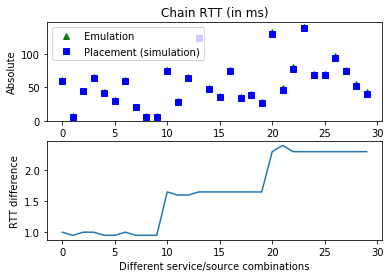

In [31]:
# 1.1 chain delays
x_chain = range(len(emu_delays))
plt.figure(1)
plt.subplot(2, 1, 1)
plt.plot(x_chain, emu_chain_rtt, 'g^', x_chain, sim_chain_rtt, 'bs')
# plt.xticks(x_chain, sim_chain_length)
plt.legend(['Emulation', 'Placement (simulation)'])
plt.ylabel('Absolute')
plt.title('Chain RTT (in ms)')

# 1.2 chain delay difference emu - sim
chain_diffs = [emu_chain_rtt[i]-sim_chain_rtt[i] for i in range(len(emu_chain_rtt))]
plt.subplot(2, 1, 2)
plt.plot(x_chain, chain_diffs)
# plt.xticks(x_chain, sim_chain_length)
plt.xlabel('Different service/source combinations')
plt.ylabel('RTT difference')

# FIXME: saving doesn't seem to work
plt.savefig('plots/{}-chainRtt.pdf'.format(prefix), bbox_inches='tight') 
plt.show()

Again, also for Airtel, there are clear steps at 10, 20, showing the impact of different chain lengths (10x fw1, 10x fw2, 10x fw3). TODO: Directly show chain lengths.

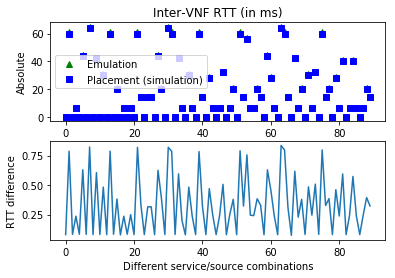

In [32]:
# 2.1 inter-VNF delays
x_vnfs = range(len(emu_vnf_rtt))
plt.figure(2)
plt.subplot(2, 1, 1)
plt.plot(x_vnfs, emu_vnf_rtt, 'g^', x_vnfs, sim_vnf_rtt, 'bs')
# plt.errorbar(x_vnfs, emu_vnf_rtt, yerr=emu_vnf_std, fmt='none', ecolor='black', capsize=2)
# plt.xticks(x_vnfs, sim_vnf_length)
plt.legend(['Emulation', 'Placement (simulation)'])
plt.ylabel('Absolute')
plt.title('Inter-VNF RTT (in ms)')

# 2.2 inter-VNF delay difference: emu - sim
vnf_diffs = [emu_vnf_rtt[i]-sim_vnf_rtt[i] for i in range(len(emu_vnf_rtt))]
plt.subplot(2, 1, 2)
plt.plot(x_vnfs, vnf_diffs)
# plt.xticks(x_vnfs, sim_vnf_length)
plt.xlabel('Different service/source combinations')
plt.ylabel('RTT difference')

plt.savefig('plots/{}-vnfRtt.pdf'.format(prefix), bbox_inches='tight')
plt.show()